# Workflow of Kaggle Competition

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_origin = pd.read_csv('train.csv')
holdout_origin = pd.read_csv('test.csv')


In [3]:
train = train_origin.copy()
holdout = holdout_origin.copy()

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [6]:
def processing(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    df = create_dummies(df, ["Age_categories", "Fare_categories","Title", "Cabin_type", "Sex"])
    
    return df

train = processing(train)
holdout = processing(holdout)


### Explore Data

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 43 columns):
PassengerId                   891 non-null int64
Survived                      891 non-null int64
Pclass                        891 non-null int64
Name                          891 non-null object
Sex                           891 non-null object
Age                           891 non-null float64
SibSp                         891 non-null int64
Parch                         891 non-null int64
Ticket                        891 non-null object
Fare                          891 non-null float64
Embarked                      891 non-null object
Age_categories                891 non-null category
Fare_categories               891 non-null category
Title                         891 non-null object
Cabin_type                    891 non-null object
Age_categories_Missing        891 non-null uint8
Age_categories_Infant         891 non-null uint8
Age_categories_Child          891 non-null uin

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbf525344a8>,
      dtype=object)

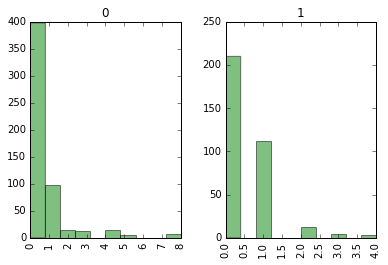

In [30]:
train.hist(column='SibSp', by='Survived', alpha=0.5, color='green')   



In [9]:
sibsp_pivot = train.pivot_table(index='SibSp', values='Survived')
sibsp_pivot


,Survived
SibSp,
0,0.345395
1,0.535885
2,0.464286
3,0.250000
4,0.166667
5,0.000000
8,0.000000


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbf5278cd68>,
      dtype=object)

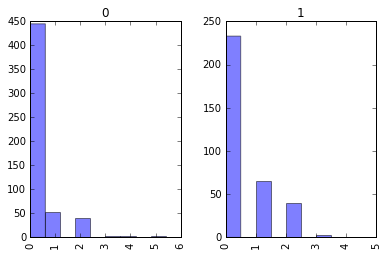

In [28]:
train.hist(column='Parch', by='Survived', alpha=0.5, color='blue')



In [11]:
def make_family(df):
    df['family'] = df['SibSp'] + df['Parch']
    return df


In [12]:
train = make_family(train)
holdout = make_family(holdout)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Cabin_type_C,Cabin_type_D,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_T,Cabin_type_Unknown,Sex_female,Sex_male,family
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,0,0,0,0,0,1,0,1,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,1,0,0,0,0,0,0,1,0,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0,0,0,0,0,0,1,1,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,1,0,0,0,0,0,0,1,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,0,0,0,0,0,0,1,0,1,0


In [14]:
def make_isalone(df):
    df['isalone'] = 0
    df.loc[df['SibSp'] + df['Parch'] == 0, 'isalone'] = 1 
    #df.loc[df['SibSp'] + df['Parch'] >= 1, 'isalone'] = 0
    return df

train = make_isalone(train)
holdout = make_isalone(holdout)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Cabin_type_D,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_T,Cabin_type_Unknown,Sex_female,Sex_male,family,isalone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,0,0,0,0,1,0,1,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,0,0,0,0,0,0,1,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0,0,0,0,0,1,1,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,0,0,0,0,0,0,1,0,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,0,0,0,0,0,1,0,1,0,1


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbf523edda0>,
      dtype=object)

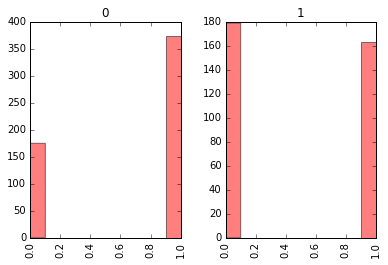

In [31]:
train.hist(column='isalone', by='Survived', alpha=0.5, color='red')  



### Feature Transformation

In [15]:
def processing(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    df = create_dummies(df, ["Age_categories", "Fare_categories","Title", "Cabin_type", "Sex"])
    df = make_isalone(df)
    return df

train = train_origin.copy()
holdout = holdout_origin.copy()
train = processing(train)
holdout = processing(holdout)

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 44 columns):
PassengerId                   891 non-null int64
Survived                      891 non-null int64
Pclass                        891 non-null int64
Name                          891 non-null object
Sex                           891 non-null object
Age                           891 non-null float64
SibSp                         891 non-null int64
Parch                         891 non-null int64
Ticket                        891 non-null object
Fare                          891 non-null float64
Embarked                      891 non-null object
Age_categories                891 non-null category
Fare_categories               891 non-null category
Title                         891 non-null object
Cabin_type                    891 non-null object
Age_categories_Missing        891 non-null uint8
Age_categories_Infant         891 non-null uint8
Age_categories_Child          891 non-null uin

### Feature Selection

In [17]:
def feature_selection(df):
    # Remove non-numeric columns, columns that have null values
    df = df.select_dtypes([np.number]).dropna(axis=1)
    all_X = df[df.columns.drop(['PassengerId', 'Survived'])]  
    all_y = df['Survived']
    rf = RandomForestClassifier(random_state=1)
    selector = RFECV(rf, cv=10)
    selector.fit(all_X, all_y)
    optimized_columns = list(all_X.columns[selector.support_])   
    print(optimized_columns)
    return optimized_columns

    

In [18]:
optimized_columns = feature_selection(train)


['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing', 'Age_categories_Infant', 'Age_categories_Young Adult', 'Fare_categories_12-50', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown', 'Sex_female', 'Sex_male', 'isalone']


/dataquest/system/env/python3/lib/python3.4/site-packages/sklearn/utils/__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


In [19]:
def select_model(df, features):
    all_X = df[features]
    all_y = df['Survived']
    
    models_dict = [
        {
            'name': 'LogisticRegression',
            'estimator': LogisticRegression(),
            'hyperparameters': {
                "solver": ["newton-cg", "lbfgs", "liblinear"]  
            }
        },
        {
            'name': 'KNeighborsClassifier', 
            'estimator': KNeighborsClassifier(),
            'hyperparameters': {
                "n_neighbors": range(1,20,2),
                "weights": ["distance", "uniform"],
                "algorithm": ["ball_tree", "kd_tree", "brute"],  
                "p": [1,2]
            }
        },
        {
            'name': 'RandomForestClassifier', 
            'estimator': RandomForestClassifier(random_state=1),
            'hyperparameters': {
                "n_estimators": [4, 6, 9],
                "criterion": ["entropy", "gini"],
                "max_depth": [2, 5, 10],
                "max_features": ["log2", "sqrt"],
                "min_samples_leaf": [1, 5, 8],
                "min_samples_split": [2, 3, 5]
            }
        }
    ]
    
    for model in models_dict:
        grid = GridSearchCV(model['estimator'], 
                            param_grid = model['hyperparameters'],
                            cv=10)
        grid.fit(all_X, all_y)
        model['best_estimator'] = grid.best_estimator_
        model['best_param'] = grid.best_params_
        model['best_score'] = grid.best_score_
        print(model['name'])
        print('best params: {}'.format(grid.best_params_))
        print('best score: {}\n'.format(grid.best_score_))
        
    return models_dict
    

In [20]:
models = select_model(train, holdout, optimized_columns)
models

LogisticRegression
best params: {'solver': 'liblinear'}
best score: 0.8204264870931538

KNeighborsClassifier
best params: {'p': 1, 'weights': 'uniform', 'algorithm': 'brute', 'n_neighbors': 5}
best score: 0.7755331088664422

RandomForestClassifier
best params: {'min_samples_leaf': 1, 'min_samples_split': 5, 'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 4, 'max_depth': 5}
best score: 0.8294051627384961



[{'best_estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
            penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
            verbose=0, warm_start=False),
  'best_param': {'solver': 'liblinear'},
  'best_score': 0.8204264870931538,
  'estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
            penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
            verbose=0, warm_start=False),
  'hyperparameters': {'solver': ['newton-cg', 'lbfgs', 'liblinear']},
  'name': 'LogisticRegression'},
 {'best_estimator': KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
             metric_params=None, n_jobs=1, n_neighbors=5, p=1,
             weights='uniform'),
  'best_param': {'algorithm': 'brute',
   'n_neighb

### Submission file

In [26]:
def save_submission_file(best_model, holdout, features, filename):
    holdout_predictions = best_model.predict(holdout[features])   
    submission = pd.DataFrame({'PassengerId': holdout['PassengerId'],
                              'Survived': holdout_predictions})
    submission.to_csv(filename, index=False)
    

In [27]:
best_model = models[2]['best_estimator']
save_submission_file(best_model, holdout, optimized_columns, 'submission_3.csv')   

